# Tweet sentiment analysis - Group 2

The approach consists in testing a Naive Bayes baseline model 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from tqdm.notebook import tqdm # progress bars
import re # RegEx
import string

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

# general NLP preprocessing and basic tools
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import wordnet

# train/test split
from sklearn.model_selection import train_test_split
# basic machine learning models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
# our evaluation metric for sentiment classification
from sklearn.metrics import fbeta_score

from easydict import EasyDict

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# install HuggingFace's transformers library
! pip install transformers

In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/submission/sumbission.csv
/kaggle/input/eurecom-aml-2023-challenge-3/sample_submission.csv
/kaggle/input/eurecom-aml-2023-challenge-3/train.csv
/kaggle/input/eurecom-aml-2023-challenge-3/test.csv
/kaggle/input/submission-1/submission(1).csv
/kaggle/input/outputs/config.json
/kaggle/input/outputs/merges.txt
/kaggle/input/outputs/scheduler(1).pt
/kaggle/input/outputs/training_args.bin
/kaggle/input/outputs/vocab.json
/kaggle/input/outputs/tokenizer_config.json
/kaggle/input/outputs/pytorch_model.bin
/kaggle/input/outputs/special_tokens_map.json
/kaggle/input/outputs/model_args.json
/kaggle/input/outputs/optimizer.pt


## Loading the data

In [4]:
train_df = pd.read_csv('/kaggle/input/eurecom-aml-2023-challenge-3/train.csv')
test_df = pd.read_csv('/kaggle/input/eurecom-aml-2023-challenge-3/test.csv')

## Quick data inspection

In [5]:
len(train_df)+len(test_df)

27480

In [6]:
train_df.head()

,textID,text,selected_text,sentiment
0,28ac06f416,good luck with your auction,good luck with your auction,positive
1,92098cf9a7,Hmm..You can`t judge a book by looking at its ...,Hmm..You can`t judge a book by looking at its ...,neutral
2,7858ff28f2,"Hello, yourself. Enjoy London. Watch out for ...",They`re mental.,negative
3,b0c9c67f32,We can`t even call you from belgium sucks,m suck,negative
4,7b36e9e7a5,not so good mood..,not so good mood..,negative


In [7]:
test_df.head()

,textID,text,selected_text
0,102f98e5e2,Happy Mother`s Day hahaha,Happy Mother`s Day
1,033b399113,"Sorry for the triple twitter post, was having ...","Sorry for the triple twitter post, was having ..."
2,c125e29be2,thats much better than the flu syndrome!,thats much better
3,b91e2b0679,Aww I have a tummy ache,tummy ache
4,1a46141274,hey chocolate chips is good. i want a snack ...,good.


## Data exploration

### Positive, Neutral & Negative data points

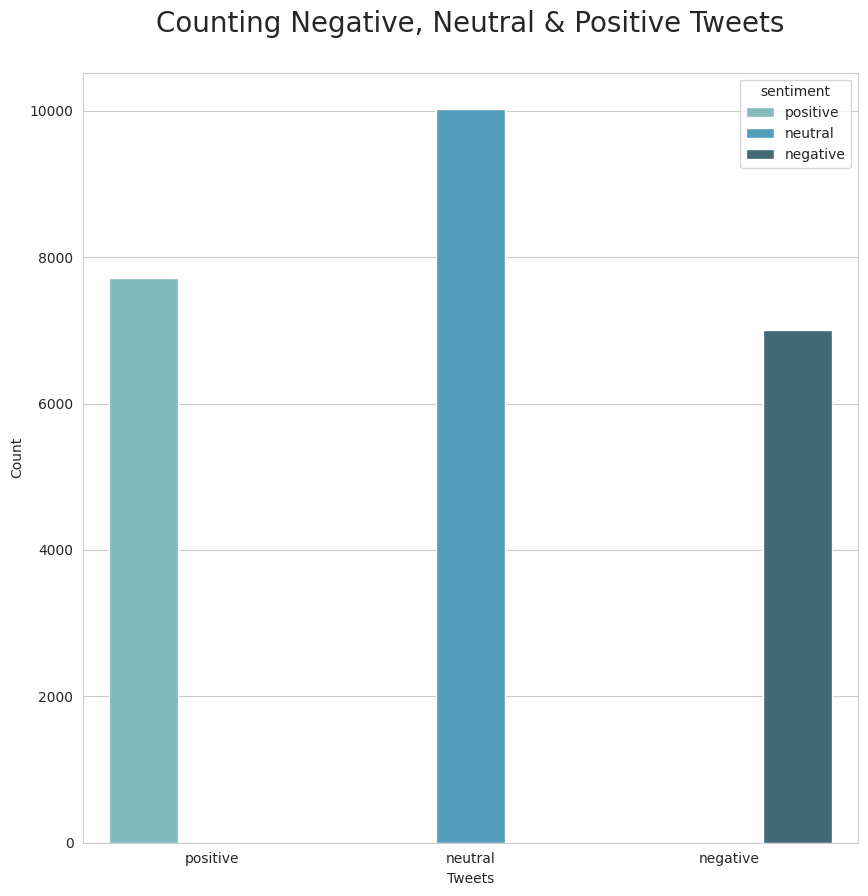

In [8]:
plt.figure(figsize=(10,10))
sns.countplot(data=train_df, x='sentiment', hue='sentiment', palette=sns.color_palette("GnBu_d", 3))
plt.title("Counting Negative, Neutral & Positive Tweets\n",fontsize=20)
plt.xlabel('Tweets')
plt.ylabel("Count")
plt.show()

### Length of tweets

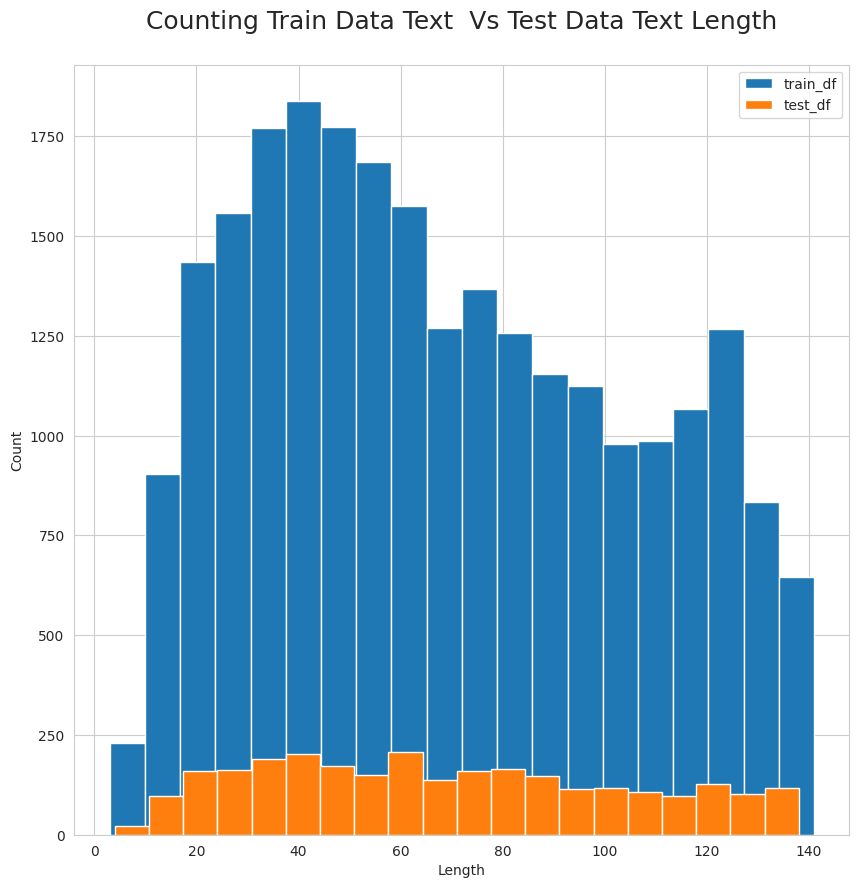

In [9]:
tweet_len_train = train_df["text"].str.len()
tweet_len_test = test_df["text"].str.len()

plt.figure(figsize=(10,10))
plt.hist(tweet_len_train, bins=20,label='train_df')
plt.hist(tweet_len_test , bins=20, label='test_df')
plt.title("Counting Train Data Text  Vs Test Data Text Length\n",fontsize=18)
plt.xlabel('Length')
plt.ylabel("Count")
plt.legend()
plt.show()

Are there any differences in length for positive, neutral and negative tweets?

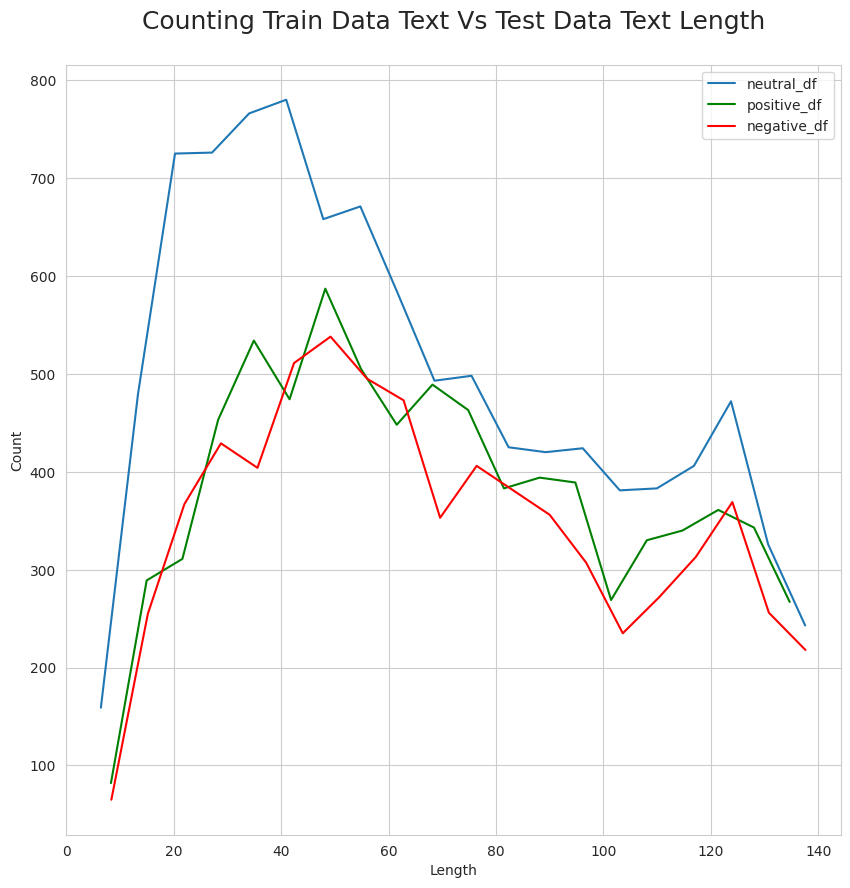

In [10]:
# datasett der bare negative er 
negative_df = train_df[train_df['sentiment'] == "negative"]
# datasett der bare nøytrale er
neutral_df = train_df[train_df['sentiment'] == "neutral"]
# datasett der bare positive er
positive_df = train_df[train_df['sentiment'] == "positive"]

tweet_len_neg = negative_df["text"].str.len()
tweet_len_neu = neutral_df["text"].str.len()
tweet_len_pos = positive_df["text"].str.len()

plt.figure(figsize=(10,10))

# Compute histogram for tweet_len_neu
counts_neu, bin_edges_neu = np.histogram(tweet_len_neu, bins=20)
counts_neu = counts_neu
bin_centers_neu = (bin_edges_neu[:-1] + bin_edges_neu[1:]) / 2.
plt.plot(bin_centers_neu, counts_neu, label='neutral_df')

# Compute histogram for tweet_len_pos
counts_pos, bin_edges_pos = np.histogram(tweet_len_pos, bins=20)
counts_pos = counts_pos
bin_centers_pos = (bin_edges_pos[:-1] + bin_edges_pos[1:]) / 2.
plt.plot(bin_centers_pos, counts_pos, label='positive_df', color='green')

# Compute histogram for tweet_len_neg
counts_neg, bin_edges_neg = np.histogram(tweet_len_neg, bins=20)
counts_neg = counts_neg
bin_centers_neg = (bin_edges_neg[:-1] + bin_edges_neg[1:]) / 2.
plt.plot(bin_centers_neg, counts_neg, label='negative_df', color='red')

plt.title("Counting Train Data Text Vs Test Data Text Length\n", fontsize=18)
plt.xlabel('Length')
plt.ylabel("Count")
plt.legend()
plt.show()

**write conclusions**

### Average word length for each sentiment

In [11]:
negative_df["avg_word_len"] = negative_df["text"].apply(lambda x: 1/(len(x.split()))*sum([len(w) for w in x.split()]))
average_negative = negative_df["avg_word_len"].mean()
print("Average word length for negative tweets:", average_negative)

neutral_df["avg_word_len"] = neutral_df["text"].apply(lambda x: 1/(len(x.split()))*sum([len(w) for w in x.split()]))
average_neutral = neutral_df["avg_word_len"].mean()
print("Average word length for neutral tweets:", average_neutral)

positive_df["avg_word_len"] = positive_df["text"].apply(lambda x: 1/(len(x.split()))*sum([len(w) for w in x.split()]))
average_positive = positive_df["avg_word_len"].mean()
print("Average word length for positive tweets:", average_positive)

Average word length for negative tweets: 4.35533043832773
Average word length for neutral tweets: 4.466700855843504
Average word length for positive tweets: 4.533448984672624


/tmp/ipykernel_22/3162887586.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df["avg_word_len"] = negative_df["text"].apply(lambda x: 1/(len(x.split()))*sum([len(w) for w in x.split()]))
/tmp/ipykernel_22/3162887586.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neutral_df["avg_word_len"] = neutral_df["text"].apply(lambda x: 1/(len(x.split()))*sum([len(w) for w in x.split()]))
/tmp/ipykernel_22/3162887586.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In conclusion, the average word length does not vary much among the different sentiments.

### Word clouds visualization per class

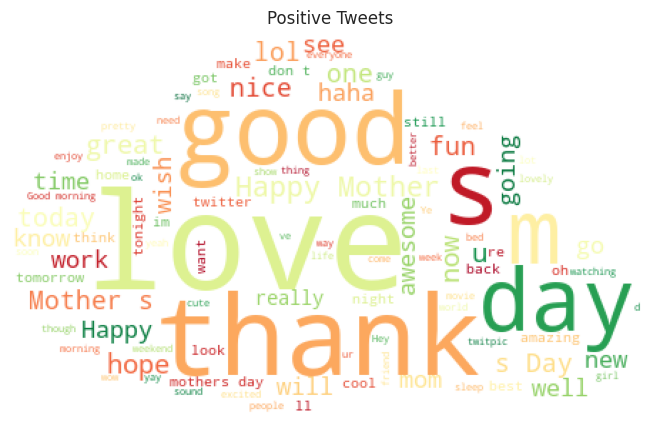

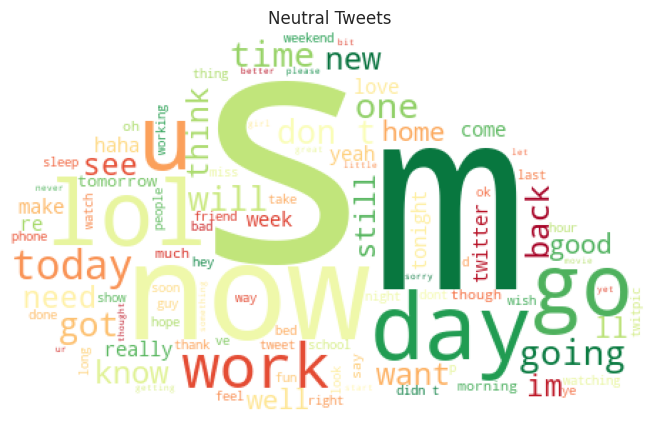

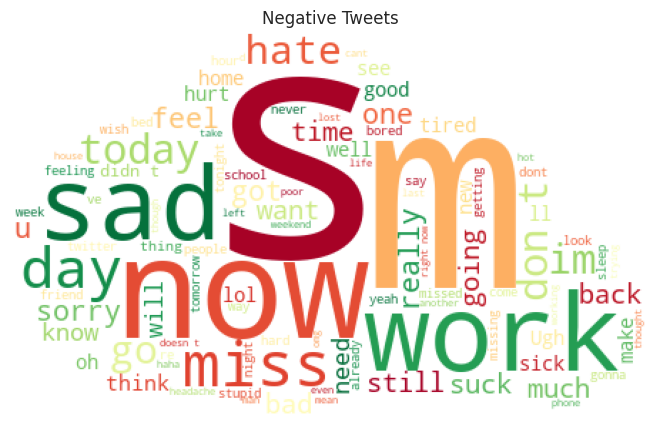

In [12]:
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
stopword = set(STOPWORDS)
import requests
from io import BytesIO
from PIL import Image

# From URL
response = requests.get("https://raw.githubusercontent.com/R-CoderDotCom/samples/main/wordcloud-mask-2.jpg")
wordcloud_mask = np.array(Image.open(BytesIO(response.content)))

positive_tweet_text=" ".join(positive_df["text"].tolist())

wordcloud=WordCloud(stopwords=stopword,width=500,height=500,mask=wordcloud_mask,max_words=100,colormap='RdYlGn', background_color="white").generate(positive_tweet_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.title("Positive Tweets")
plt.show()

neutral_tweet_text=" ".join(neutral_df["text"].tolist())

wordcloud=WordCloud(stopwords=stopword,width=500,height=500,mask=wordcloud_mask,max_words=100,colormap='RdYlGn', background_color="white").generate(neutral_tweet_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.title("Neutral Tweets")
plt.show()

negative_tweet_text=" ".join(negative_df["text"].tolist())

wordcloud=WordCloud(stopwords=stopword,width=500,height=500,mask=wordcloud_mask,max_words=100,colormap='RdYlGn', background_color="white").generate(negative_tweet_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.title("Negative Tweets")
plt.show()

### Emojis

In [13]:
! pip install emoji

In [14]:
import emoji

Count the number of emojis present in the whole dataset

In [15]:
emoji_list = list(emoji.EMOJI_DATA.keys())
count_emoji = 0
for tw in train_df.text:
    words = tw.split(' ') # separate words by white spaces
    for w in words:
        if w in emoji_list:
            count_emoji += 1
print(f'Number of emojis in the whole training dataset: {count_emoji}')

Number of emojis in the whole training dataset: 0


### Emoticons

In [16]:
! pip install emot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 3.8 MB/s eta 0:00:00


In [17]:
from emot.emo_unicode import EMOTICONS_EMO

Insert some common emoticons in the EMOTICONS_EMO dictionary that are currently missing:

In [18]:
EMOTICONS_EMO['<3']='heart'
EMOTICONS_EMO['*-*']='dreamy face'
EMOTICONS_EMO['*_*']='dreamy face'

Count the emoticons present in the whole dataset

In [19]:
count_emoticons = 0
for tw in train_df.text:
    words = tw.split(' ')
    for w in words:
        if w in EMOTICONS_EMO:
            count_emoticons += 1
print(f'Number of emoticons in the whole training dataset: {count_emoticons}')

Number of emoticons in the whole training dataset: 510


In [20]:
count_emoticons = 0

for tw in negative_df.text:
    words = tw.split(' ')
    for w in words:
        if w in EMOTICONS_EMO:
            count_emoticons += 1
print(f'Average number of emoticons in the negative tweets: {count_emoticons/len(negative_df.index)}')
print(f'Total number of emoticons in the negative tweets: {count_emoticons}')

Average number of emoticons in the negative tweets: 0.01756390118520634
Total number of emoticons in the negative tweets: 123


In [21]:
count_emoticons = 0

for tw in neutral_df.text:
    words = tw.split(' ')
    for w in words:
        if w in EMOTICONS_EMO:
            count_emoticons += 1
print(f'Average number of emoticons in the neutral tweets: {count_emoticons/len(neutral_df)}')
print(f'Total number of emoticons in the neutral tweets: {count_emoticons}')

Average number of emoticons in the neutral tweets: 0.015671790776602117
Total number of emoticons in the neutral tweets: 157


In [22]:
count_emoticons = 0

for tw in positive_df.text:
    words = tw.split(' ')
    for w in words:
        if w in EMOTICONS_EMO:
            count_emoticons += 1
print(f'Average number of emoticons in the positive tweets: {count_emoticons/len(positive_df)}')
print(f'Total number of emoticons in the positive tweets: {count_emoticons}')

Average number of emoticons in the positive tweets: 0.029827519128517704
Total number of emoticons in the positive tweets: 230


### Punctuation frequency
The absence of punctuation or minimal use of punctuation might indicate a more neutral or objective tone.

In [23]:
def calculate_punctuation_count(tweet):
    count = sum([1 for char in tweet if char in string.punctuation])
    return count

negative_punctuation_freq = negative_df["text"].apply(calculate_punctuation_count).mean()
print("Punctuation frequency of negative tweets: ",negative_punctuation_freq)

neutral_punctuation_freq = neutral_df["text"].apply(calculate_punctuation_count).mean()
print("Punctuation frequency of neutral tweets: ",neutral_punctuation_freq)

positive_punctuation_freq = positive_df["text"].apply(calculate_punctuation_count).mean()
print("Punctuation frequency of positive tweets: ",positive_punctuation_freq)

Punctuation frequency of negative tweets:  3.764815079251749
Punctuation frequency of neutral tweets:  3.348971850668796
Punctuation frequency of positive tweets:  3.655946051095837


However, no significant differences are found in puntuation frequency for the different sentiments.

### Hashtag analysis

In [24]:
def extract_hashtags(tweet):
    hashtags = re.findall(r'#\w+', tweet)
    return hashtags

df_copy = train_df.copy()
df_copy["hashtags"] = df_copy["text"].apply(extract_hashtags)

sentiment_hashtags = df_copy.groupby('sentiment')['hashtags'].sum()

for sentiment, hashtags in sentiment_hashtags.items():
    print(f"Sentiment: {sentiment}")
    hashtag_counts = pd.Series(hashtags).value_counts()
    print(hashtag_counts)
    print()

Sentiment: negative
#bgt           5
#fail          5
#BGT           5
#fb            4
#itsucks       3
              ..
#antiboyle     1
#edaust09      1
#2923848932    1
#BSNL          1
#BEA09         1
Length: 128, dtype: int64

Sentiment: neutral
#fb                     11
#followfriday            6
#starwarsday             6
#2                       3
#hhrs                    3
                        ..
#iva09                   1
#newcastle               1
#liesgirlstell           1
#follow                  1
#mishaneedschapstick     1
Length: 184, dtype: int64

Sentiment: positive
#fb                 14
#followfriday       11
#juddday             5
#1                   4
#SanctuarySunday     4
                    ..
#mothersday          1
#firefly             1
#tweetbud            1
#Beijing             1
#Migraine            1
Length: 118, dtype: int64



### Data exploration conclusions
All in all, no relevant meta information that could aid the sentiment analysis task can be extracted from the data at hand. Emojis are absent, emoticons and hashtags are very rare and average word lengths/punctuation frequencies are very similar among the different sentiments.

## Data pre-processing

### Text cleaning

In [25]:
stopwords = set(STOPWORDS)
stopwords.update(["nan"])

In [26]:
# Function for converting emoticons into word
def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        pattern = re.escape(emot)  # Escape the parentheses in the emoticon
        text = re.sub(pattern, "_".join(EMOTICONS_EMO[emot].replace(",","").split()), text)
    return text

In [27]:
# Example
text = "Hello :-) :-)"
convert_emoticons(text)

'Hello Happy_face_smiley Happy_face_smiley'

In [28]:
def text_clean(x, heavy=False):
    ### Light
    x = x.lower() # lowercase everything
    x = x.encode('ascii', 'ignore').decode()  # remove unicode characters
    x = re.sub(r'https*\S+', ' ', x) # remove links
    x = re.sub(r'http*\S+', ' ', x)
    # cleaning up text
    x = re.sub(r'\'\w+', '', x) 
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)
    x = re.sub(r'\s[^\w\s]\s', '', x)
    
    ### Heavy
    if heavy:
        x = ' '.join([word for word in x.split(' ') if word not in stopwords])
        x = re.sub(r'@\S', '', x) # remove user handles
        x = re.sub(r'#\S+', ' ', x) # remove hashtags
        x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
        # remove single letters and numbers surrounded by space
        x = re.sub(r'\s[a-z]\s|\s[0-9]\s', ' ', x)
        x = convert_emoticons(x) # convert emoticons into word
        

    return x

### Lemmatization (heavy cleaning)
This is where a library of words is used to remove the inflectional endings of words to return them to their base form, which is known as the lemma. For example, instead of “running” or “runs”, we would just get “run”.

In [29]:
# Download WordNet data
nltk.data.path.append('/kaggle/working/nltk_data')
nltk.download('wordnet', quiet=True, raise_on_error=True, download_dir='/kaggle/working/nltk_data')

True

In [30]:
nltk.download('punkt', quiet=True, raise_on_error=True, download_dir='/kaggle/working/nltk_data')

True

In [31]:
nltk.download('averaged_perceptron_tagger', quiet=True, raise_on_error=True, download_dir='/kaggle/working/nltk_data')

True

In [32]:
import zipfile

# Specify the path to the WordNet corpus zip file
wordnet_zip_path = '/kaggle/working/nltk_data/corpora/wordnet.zip'

# Extract the contents of the zip file
with zipfile.ZipFile(wordnet_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/nltk_data/corpora/')

In [33]:
def lemmatize_word(word, tag):
    tag_mapping = {
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV,
        'J': wordnet.ADJ
    }
    tag = tag_mapping.get(tag[0], wordnet.NOUN)

    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word, tag)

In [34]:
def lemmatize_tweet(tweet):
    tokens = word_tokenize(tweet)
    tagged_tokens = pos_tag(tokens)
    lemmatized_tokens = [lemmatize_word(token, tag) for token, tag in tagged_tokens]
    return ' '.join(lemmatized_tokens)

The pos_tag() function from the NLTK library is used to assign part-of-speech (POS) tags to words in a given sentence or text. POS tagging is the process of labeling the words in a text with their respective parts of speech, such as nouns, verbs, adjectives, adverbs, etc.

In [35]:
# we create a validation dataset from the training data
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=0)

We start off by converting the labels to numbers. This is a requirement for the submission and numerical inputs are generally more compatible with machine learning libraries.

In [36]:
target_conversion = {
    'neutral': 0,
    'positive': 1,
    'negative': 2
}

In [37]:
train_df['target'] = train_df['sentiment'].map(target_conversion)
val_df['target'] = val_df['sentiment'].map(target_conversion)

### Config dictionary

In [38]:
config = {
    "models":["bert-base-uncased","roberta-base","cardiffnlp/twitter-roberta-base-sentiment"],
    "model_name":"roberta-base",
    "dataloaders":{
        "train_batch_size": 4,
        "val_batch_size": 32
    },
    "optim":{
        "lr": 1e-5,
        "eps": 1e-8
    }
}

config = EasyDict(config)

## Training a simple classifier (Baseline)

We are training a naive Bayes classifier on the Bag-of-Words features of the training data:

https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html

It is already built into the sklearn library:

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

Keep in mind that not only storing the features is challenging but also processing them. A simple SVM may be quite slow on such high-dimensional features. Naive Bayes works well with Bag-of-Words.



## Test 1: apply Light cleaning, no lemmatization

In [39]:
train_df['cleaned_text'] = train_df.text.apply(text_clean, heavy=False)
val_df['cleaned_text'] = val_df.text.apply(text_clean, heavy=False)
test_df['cleaned_text'] = test_df.text.apply(text_clean, heavy=False)

### Bag-of-words with CountVectorizer()

In [40]:
count_vect = CountVectorizer()

In [41]:
# here we are obtaining the vocabulary from the training data minus validation data
# you may want to change this to the full training data for the final submission
X_train_counts = count_vect.fit_transform(list(train_df['cleaned_text'].values))
X_val_counts = count_vect.transform(list(val_df['cleaned_text'].values))
X_test_counts = count_vect.transform(list(test_df['cleaned_text'].values))

In [42]:
print('Train feature shape:', X_train_counts.shape)
print('Train feature shape:', X_val_counts.shape)
print('Test feature shape:', X_test_counts.shape)

Train feature shape: (22258, 22921)
Train feature shape: (2474, 22921)
Test feature shape: (2748, 22921)


### Naive Bayes classifier

In [43]:
%%time
clf = MultinomialNB().fit(X_train_counts, train_df['target'])

CPU times: user 8.21 ms, sys: 2.02 ms, total: 10.2 ms
Wall time: 11.7 ms


In [44]:
val_predictions_nb = clf.predict(X_val_counts)

In [45]:
accuracy = (val_predictions_nb == val_df['target'].values).mean()
print('The accuracy of our multinomial Naive Bayes classifier with Light cleaning is: {:.2f}%'.format(accuracy*100))

The accuracy of our multinomial Naive Bayes classifier with Light cleaning is: 65.32%


In [46]:
fbeta = fbeta_score(val_df['target'].values, val_predictions_nb, average='macro', beta=1.0)
print('The fbeta score is:', fbeta)

The fbeta score is: 0.6515135892041947


## Test 2: apply Heavy cleaning + lemmatization

In [47]:
train_df['cleaned_text'] = train_df.text.apply(text_clean, heavy=True)
val_df['cleaned_text'] = val_df.text.apply(text_clean, heavy=True)
test_df['cleaned_text'] = test_df.text.apply(text_clean, heavy=True)

In [48]:
# apply lemmatization to the sets
train_df['text_lemmatized'] = train_df.cleaned_text.apply(lemmatize_tweet)
val_df['text_lemmatized'] = val_df.cleaned_text.apply(lemmatize_tweet)
test_df['text_lemmatized'] = test_df.cleaned_text.apply(lemmatize_tweet)

### Bag-of-words with CountVectorizer()

In [49]:
count_vect = CountVectorizer()

In [50]:
# here we are obtaining the vocabulary from the training data minus validation data
# you may want to change this to the full training data for the final submission
X_train_counts = count_vect.fit_transform(list(train_df['text_lemmatized'].values))
X_val_counts = count_vect.transform(list(val_df['text_lemmatized'].values))
X_test_counts = count_vect.transform(list(test_df['text_lemmatized'].values))

In [51]:
print('Train feature shape:', X_train_counts.shape)
print('Train feature shape:', X_val_counts.shape)
print('Test feature shape:', X_test_counts.shape)

Train feature shape: (22258, 19838)
Train feature shape: (2474, 19838)
Test feature shape: (2748, 19838)


### Naive Bayes classifier

In [52]:
%%time
clf = MultinomialNB().fit(X_train_counts, train_df['target'])

CPU times: user 6.86 ms, sys: 995 µs, total: 7.85 ms
Wall time: 7.51 ms


In [53]:
val_predictions_nb = clf.predict(X_val_counts)

In [54]:
accuracy = (val_predictions_nb == val_df['target'].values).mean()
print('The accuracy of our multinomial Naive Bayes classifier with Heavy cleaning + lemmatization is: {:.2f}%'.format(accuracy*100))

The accuracy of our multinomial Naive Bayes classifier with Heavy cleaning + lemmatization is: 64.63%


In [55]:
fbeta = fbeta_score(val_df['target'].values, val_predictions_nb, average='macro', beta=1.0)
print('The fbeta score is:', fbeta)

The fbeta score is: 0.6469736944969088


##  Loading Tokenizer and Encoding our Data

In [56]:
from transformers import AutoTokenizer
from torch.utils.data import TensorDataset

### Check emoticons compatibility of the chosen model

In [57]:
for mod in config.models:
    tokenizer = AutoTokenizer.from_pretrained(
        mod,
        do_lower_case=True
    )
    cnt = 0
    for e in EMOTICONS_EMO:
        tokenized = tokenizer.decode(tokenizer.encode(e)).strip("</s>").strip()
        if e not in tokenized:
            cnt += 1
    print(f"{cnt/len(emoji_list)} of the emojis are not identified by the tokenizer of model: {mod}.")

0.046482146630044366 of the emojis are not identified by the tokenizer of model: bert-base-uncased.


0.005493344601732516 of the emojis are not identified by the tokenizer of model: roberta-base.


0.005493344601732516 of the emojis are not identified by the tokenizer of model: cardiffnlp/twitter-roberta-base-sentiment.


As can be seen by the results, the tokenizers of all the models considered recognize almost all the emoticons present in the emot.EMOTICONS_EMO base.

Since Twitter-RoBERTa was trained specifically for the task of tweets sentiment analysis, we chose to implement it.

Given that the chosen model is already able to recognize almost all the emoticons, no special conversion is applied.

In [58]:
config.model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(
    config.model_name,
    do_lower_case=True
)

### Test with Light cleaning

In [59]:
train_df['cleaned_text'] = train_df.text.apply(text_clean, heavy=False)
val_df['cleaned_text'] = val_df.text.apply(text_clean, heavy=False)
test_df['cleaned_text'] = test_df.text.apply(text_clean, heavy=False)

### Encoding training and validation data

In [60]:
encoded_data_train = tokenizer.batch_encode_plus(
    list(train_df.cleaned_text.values),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    list(val_df.cleaned_text.values),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df.target.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_df.target.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [61]:
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val, 
                            attention_masks_val,
                           labels_val)

In [62]:
len(dataset_train)

22258

In [63]:
dataset_val.tensors

(tensor([[    0,   891,   360,  ...,     1,     1,     1],
         [    0,  8877,   399,  ...,     1,     1,     1],
         [    0,  1039,  1215,  ...,     1,     1,     1],
         ...,
         [    0,   295,  9877,  ...,     1,     1,     1],
         [    0, 29784,   939,  ...,     1,     1,     1],
         [    0,  2678,     8,  ...,     1,     1,     1]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([0, 0, 0,  ..., 1, 0, 2]))

## Setting up the pretrained model

In [64]:
from transformers import AutoModelForSequenceClassification

In [65]:
model = AutoModelForSequenceClassification.from_pretrained(
                                      config.model_name, 
                                      num_labels = len(target_conversion),
                                      output_attentions = False,
                                      output_hidden_states = False
                                     )

## Creating Data Loaders

In [66]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [67]:
dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=config.dataloaders.train_batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=config.dataloaders.val_batch_size
)

## Setting Up Optimizer and Scheduler

In [68]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [69]:
optimizer = AdamW(
    model.parameters(),
    lr = config.optim.lr,
    eps = config.optim.eps
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [70]:
epochs = 10

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps = len(dataloader_train)*epochs
)

## Defining our Performance Metrics

import numpy as np
from sklearn.metrics import f1_score



In [71]:
import numpy as np
from sklearn.metrics import f1_score

In [72]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'macro')

In [73]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in target_conversion.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Creating our Training Loop

In [74]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [76]:
def evaluate(dataloader_val):
    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

### Training loop

In [77]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch), 
                        leave=False, 
                        disable=False)
    
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total +=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})     
    
    #torch.save(model.state_dict(), f'Models/BERT_ft_Epoch{epoch}.model')
    
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (macro): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/5565 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.6557193292148398


  0%|          | 0/78 [00:00<?, ?it/s]

Validation loss: 0.553008629534489
F1 Score (macro): 0.8062024633579186


Epoch 2:   0%|          | 0/5565 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.5786571836581844


  0%|          | 0/78 [00:00<?, ?it/s]

Validation loss: 0.8733752601039715
F1 Score (macro): 0.8004980079899258


Epoch 3:   0%|          | 0/5565 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.4659011793079362


  0%|          | 0/78 [00:00<?, ?it/s]

Validation loss: 0.9216675780331477
F1 Score (macro): 0.8086909783431935


Epoch 4:   0%|          | 0/5565 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.3572697600834586


  0%|          | 0/78 [00:00<?, ?it/s]

Validation loss: 1.2052261271537879
F1 Score (macro): 0.785473957054537


Epoch 5:   0%|          | 0/5565 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.260414107325672


  0%|          | 0/78 [00:00<?, ?it/s]

Validation loss: 1.4167703313705249
F1 Score (macro): 0.7949967335840529


Epoch 6:   0%|          | 0/5565 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.19512434436953177


  0%|          | 0/78 [00:00<?, ?it/s]

Validation loss: 1.4027132361363142
F1 Score (macro): 0.7977229020000226


Epoch 7:   0%|          | 0/5565 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.13476967358478756


  0%|          | 0/78 [00:00<?, ?it/s]

Validation loss: 1.5732863052533224
F1 Score (macro): 0.8025871754594541


Epoch 8:   0%|          | 0/5565 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.10060203343129953


  0%|          | 0/78 [00:00<?, ?it/s]

Validation loss: 1.813257868282306
F1 Score (macro): 0.791873937224593


Epoch 9:   0%|          | 0/5565 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.07362336501238473


  0%|          | 0/78 [00:00<?, ?it/s]

Validation loss: 1.868895691921399
F1 Score (macro): 0.7940072499032294


Epoch 10:   0%|          | 0/5565 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.05008744738256189


  0%|          | 0/78 [00:00<?, ?it/s]

Validation loss: 1.9526461206185513
F1 Score (macro): 0.7923022416742405


## Evaluating our Model

In [78]:
accuracy_per_class(predictions, true_vals)

Class: neutral
Accuracy:756/997

Class: positive
Accuracy:652/788

Class: negative
Accuracy:546/689



# Evaluating the test set

In [79]:
encoded_data_test = tokenizer.batch_encode_plus(
    list(test_df.cleaned_text.values),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [80]:
dataset_test = TensorDataset(input_ids_test, 
                            attention_masks_test)

In [81]:
dataloader_test = DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False
)

In [82]:
model.eval()
predictions = []
for batch in dataloader_test:
    
    batch = tuple(b.to(device) for b in batch)
    
    inputs = {'input_ids':      batch[0],
              'attention_mask': batch[1]
              }

    with torch.no_grad():        
        outputs = model(**inputs)

    logits = outputs[0].detach().cpu().numpy()
    predictions.append(np.argmax(logits))
        

In [83]:
# map the class label "2" back to "-1"
predictions = list(map(lambda x: -1 if x == 2 else x, predictions))

In [84]:
predictions[:10]

[1, -1, 1, -1, 1, 1, 0, 0, 1, 0]

In [85]:
# Creating a submission
submission_df = pd.DataFrame()
submission_df['textID'] = test_df['textID']
submission_df['sentiment'] = predictions
submission_df.to_csv('submission.csv', index=False)

## How good is this score?

Early approaches in NLP used rule-based classifiers for sentiment analysis. A popular baseline is VADER which was published in 2014:

https://www.aaai.org/ocs/index.php/ICWSM/ICWSM14/paper/viewPaper/8109

VADER does not use any machine learning but is purely handcrafted by humans. It uses text preprocessing and lexica to determine the sentiment of a text.

In [86]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [87]:
sid = SentimentIntensityAnalyzer()

In [88]:
# We show a few prediction examples:
for doc in val_df['text'].iloc[:5].values:
    print(doc)
    print(sid.polarity_scores(doc))

 couple days?! Sheeeeit. Wish I were there. Have something at Cafe Claude for me.
{'neg': 0.0, 'neu': 0.8, 'pos': 0.2, 'compound': 0.4574}
She didn`t make the challenge
{'neg': 0.0, 'neu': 0.755, 'pos': 0.245, 'compound': 0.0772}
@_laertesgirl Ohh of course. She did stop once though, end of Dream. John Woodvine & Zoe Thorne, only ones not signed my programme
{'neg': 0.091, 'neu': 0.826, 'pos': 0.083, 'compound': -0.0516}
happy mother`s day mom. love you always
{'neg': 0.0, 'neu': 0.388, 'pos': 0.612, 'compound': 0.836}
I`m at my saddest right now. I lost my mobile phone earphones. Waz feels a little incomplete and I feel the same
{'neg': 0.27, 'neu': 0.73, 'pos': 0.0, 'compound': -0.743}


In [89]:
def vader_predict(x):
    prediction = sid.polarity_scores(x)
    prediction_list = [
        (1, prediction['pos']),
        (-1, prediction['neg']),
        (0, prediction['neu'])
    ]
    label = sorted(prediction_list, key=lambda x: x[1], reverse=True)[0][0]
    return label

In [90]:
predictions_vader = val_df['text'].apply(vader_predict)

In [91]:
accuracy = (predictions_vader == val_df['target'].values).mean()
print('The accuracy of VADER is: {:.2f}%'.format(accuracy*100))

The accuracy of VADER is: 46.52%


In [92]:
fbeta = fbeta_score(val_df['target'].values, predictions_vader, average='macro', beta=1.0)
print('The fbeta score is:', fbeta)

The fbeta score is: 0.24569800804847416


VADER performs worse! That is a good sign that our classifier learned useful generalizations from the training data (better than standard handcrafted rules).

# Bonus task: sentiment extraction
Detecting the relevant words inside the tweet which are most responsible for the attributed sentiment. For example in the phrase "I really like this song", the relevant words are: "really like".

In [93]:
# selected_text shows the words selected from text to lead to the classification stored in sentiment
train_df[['text', 'selected_text', 'sentiment']].iloc[:5]

,text,selected_text,sentiment
772,had a horrible sleep + in a rather bad mood,in a rather bad mood,negative
11840,No but this is our poor week,No but this is our poor week,negative
16482,_Blogs Congratulations lovely Japanese Childre...,Congratulations lo,positive
10802,?Happy Birthday to u? Happy Birthday to u? Ha...,?Happy,positive
13679,i can`t go tonight *Cait*,i can`t go tonight *Cait*,neutral


## Problem formulation
We formulate the task as question answering problem: given a question and a context, we train a transformer model to find the answer in the text column (the context).

We have:
- Question: sentiment column (positive, neutral or negative)
- Context: text column
- Answer: selected_text column

## Model used: RobertaForQuestionAnswering + SQuaD2
Roberta Model with a span classification head on top for extractive question-answering tasks like SQuAD (a linear layers on top of the hidden-states output to compute span start logits and span end logits).

## Prepare data in QA format
Example format below:

In [94]:
train_data = [
    {
        'context': "This tweet sentiment extraction challenge is great",
        'qas': [
            {
                'id': "00001",
                'question': "positive",
                'answers': [
                    {
                        'text': "is great",
                        'answer_start': 43
                    }
                ]
            }
        ]
    }
]

### Read the predicted sentiment for the test set and add them to the dataframe

In [95]:
# Read the CSV file into a DataFrame
csv_path='/kaggle/input/submission-1/submission(1).csv'
test_df_subm = pd.read_csv(csv_path)
# select the predicted sentiment column
pred_sentiment = test_df_subm.sentiment
# add the predicted sentiment column to the original test dataframe
test_df["sentiment"] = pred_sentiment

In [96]:
test_df.head()

,textID,text,selected_text,cleaned_text,text_lemmatized,sentiment
0,102f98e5e2,Happy Mother`s Day hahaha,Happy Mother`s Day,happy mother`s day hahaha,happy mother day hahaha,1
1,033b399113,"Sorry for the triple twitter post, was having ...","Sorry for the triple twitter post, was having ...","sorry for the triple twitter post, was having ...",sorry triple twitter post trouble stocktwits a...,-1
2,c125e29be2,thats much better than the flu syndrome!,thats much better,thats much better than the flu syndrome!,thats much well flu syndrome,1
3,b91e2b0679,Aww I have a tummy ache,tummy ache,aww i have a tummy ache,aww tummy ache,-1
4,1a46141274,hey chocolate chips is good. i want a snack ...,good.,hey chocolate chips is good. i want a snack t...,hey chocolate chip good want snack m snack,1


### Convert the sentiment column from numeral to string

In [97]:
sentiment_conversion = {
    0: 'neutral',
    1: 'positive',
    -1: 'negative'
}

In [98]:
test_df['sentiment'] = test_df['sentiment'].map(sentiment_conversion)

In [99]:
test_df.head()

,textID,text,selected_text,cleaned_text,text_lemmatized,sentiment
0,102f98e5e2,Happy Mother`s Day hahaha,Happy Mother`s Day,happy mother`s day hahaha,happy mother day hahaha,positive
1,033b399113,"Sorry for the triple twitter post, was having ...","Sorry for the triple twitter post, was having ...","sorry for the triple twitter post, was having ...",sorry triple twitter post trouble stocktwits a...,negative
2,c125e29be2,thats much better than the flu syndrome!,thats much better,thats much better than the flu syndrome!,thats much well flu syndrome,positive
3,b91e2b0679,Aww I have a tummy ache,tummy ache,aww i have a tummy ache,aww tummy ache,negative
4,1a46141274,hey chocolate chips is good. i want a snack ...,good.,hey chocolate chips is good. i want a snack t...,hey chocolate chip good want snack m snack,positive


In [100]:
# convert the datasets to numpy arrays
train = np.array(train_df.drop(columns=["cleaned_text", "text_lemmatized", "target"]))
val = np.array(val_df.drop(columns=["cleaned_text", "text_lemmatized", "target"]))
# concatenate training and validation sets
train = np.concatenate((train,val), axis=0)
test = np.array(test_df.drop(columns=["cleaned_text", "text_lemmatized"]))

In [101]:
import json
"""
Prepare training data in QA-compatible format
"""

# Adpated from https://www.kaggle.com/cheongwoongkang/roberta-baseline-starter-simple-postprocessing
def find_all(input_str, search_str):
    l1 = []
    length = len(input_str)
    index = 0
    while index < length:
        i = input_str.find(search_str, index)
        if i == -1:
            return l1
        l1.append(i)
        index = i + 1
    return l1

def do_qa_train(train):

    output = []
    for line in train:
        context = line[1]

        qas = []
        question = line[-1]
        qid = line[0]
        answers = []
        answer = line[2]
        if type(answer) != str or type(context) != str or type(question) != str:
            print(context, type(context))
            print(answer, type(answer))
            print(question, type(question))
            continue
        answer_starts = find_all(context, answer)
        for answer_start in answer_starts:
            answers.append({'answer_start': answer_start, 'text': answer.lower()})
            break
        qas.append({'question': question, 'id': qid, 'is_impossible': False, 'answers': answers})

        output.append({'context': context.lower(), 'qas': qas})
        
    return output

qa_train = do_qa_train(train)

with open('/kaggle/working/train.json', 'w') as outfile:
    json.dump(qa_train, outfile)

In [102]:
"""
Prepare testing data in QA-compatible format
"""

def do_qa_test(test):
    output = []
    for line in test:
        context = line[1]
        qas = []
        question = line[-1]
        qid = line[0]
        if type(context) != str or type(question) != str:
            print(context, type(context))
            print(answer, type(answer))
            print(question, type(question))
            continue
        answers = []
        answers.append({'answer_start': 1000000, 'text': '__None__'})
        qas.append({'question': question, 'id': qid, 'is_impossible': False, 'answers': answers})
        output.append({'context': context.lower(), 'qas': qas})
    return output

qa_test = do_qa_test(test)

with open('/kaggle/working/test.json', 'w') as outfile:
    json.dump(qa_test, outfile)

Install simple-transformers, a tool to train and test transformers model easily.

In [103]:
! pip install simpletransformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 84.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=495a295161d081c47f1212d5876ce705def7c0e7d4e7c89cafc2c3163f30f0d0
  Stored in directory: /root/.c

### Train model
Train the deepset/roberta-base-squad2 model for question answering.

In [104]:
from simpletransformers.question_answering import QuestionAnsweringModel

In [105]:
model = QuestionAnsweringModel('roberta', 
                               'deepset/roberta-base-squad2', 
                               args={'reprocess_input_data': True,
                                     'overwrite_output_dir': True,
                                     'learning_rate': 5e-5,
                                     'num_train_epochs': 3,
                                     'max_seq_length': 192,
                                     'doc_stride': 64,
                                     'fp16': False,
                                    },
                              use_cuda=True)

model.train_model('/kaggle/working/train.json')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


add example index and unique id: 100%|██████████| 24732/24732 [00:00<00:00, 698758.72it/s]


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/3092 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/3092 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/3092 [00:00<?, ?it/s]

(9276, 0.7840172198793637)

In [106]:
model = QuestionAnsweringModel('roberta', 
                               '/kaggle/input/outputs/', 
                               use_cuda=True)

### Submission

In [107]:
predictions = model.predict(qa_test)
predictions_df = pd.DataFrame.from_dict(predictions)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


add example index and unique id: 100%|██████████| 2748/2748 [00:00<00:00, 683870.14it/s]


Running Prediction:   0%|          | 0/344 [00:00<?, ?it/s]

In [108]:
predictions_df.iloc[0,0]

{'id': '102f98e5e2',
 'answer': ['happy',
  'happy mother`s day hahaha',
  'happy mother`s day',
  'happy mother`s',
  'hahaha',
  'day hahaha',
  'day',
  'mother`s day hahaha',
  'mother`s day',
  'aha',
  'mother`s',
  's',
  '`s',
  'h',
  '`']}

In [109]:
# the prediction with highest prob is the first one in the list (index 0)
selected_text_pred = [pred['answer'][0] for pred in predictions_df.iloc[0,:]]

In [110]:
submission_df = pd.DataFrame()
submission_df['textID'] = test_df['textID']
submission_df['sentiment'] = pred_sentiment
submission_df['selected_text'] = test_df['selected_text']
submission_df['selected_text_pred'] = selected_text_pred
submission_df.to_csv('submission_bonus.csv', index=False)

print("File submitted successfully.")

File submitted successfully.


In [111]:
submission_df.iloc[:5,:]

,textID,sentiment,selected_text,selected_text_pred
0,102f98e5e2,1,Happy Mother`s Day,happy
1,033b399113,-1,"Sorry for the triple twitter post, was having ...",sorry
2,c125e29be2,1,thats much better,thats much better
3,b91e2b0679,-1,tummy ache,aww i have a tummy ache
4,1a46141274,1,good.,good.


### Jaccard index

In [112]:
def Jaccard_Similarity(doc1, doc2): 
    
    # List the unique words in a document
    words_doc1 = set(doc1.lower().split()) 
    words_doc2 = set(doc2.lower().split())
    
    # Find the intersection of words list of doc1 & doc2
    intersection = words_doc1.intersection(words_doc2)

    # Find the union of words list of doc1 & doc2
    union = words_doc1.union(words_doc2)
        
    # Calculate Jaccard similarity score 
    # using length of intersection set divided by length of union set
    return float(len(intersection)) / len(union)

In [113]:
# evaluate the average Jaccard score for all the test samples
avg_jac = 0.
for pred, gt in zip(submission_df['selected_text_pred'], submission_df['selected_text']):
    avg_jac += Jaccard_Similarity(pred, gt)
avg_jac /= submission_df.shape[0]

print(f'The average Jaccard score on the test set is: {avg_jac}')

The average Jaccard score on the test set is: 0.6120256086543917
